In [1]:
!pip install pytesseract opencv-python pillow textblob pyspellchecker


In [2]:
import pytesseract
from PIL import Image
import cv2
import os
import numpy as np
import pandas as pd
from spellchecker import SpellChecker
from textblob import TextBlob
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


In [4]:
spell = SpellChecker()

def extract_text(image_path):
    image = Image.open(image_path)
    return pytesseract.image_to_string(image)

def spelling_accuracy(text):
    words = text.split()
    if not words:
        return 0
    misspelled = spell.unknown(words)
    accuracy = 1 - len(misspelled) / len(words)
    return round(accuracy, 3)

def phonetic_accuracy(text):
    words = text.split()
    if not words:
        return 0
    misspelled = spell.unknown(words)
    phonetically_correct = sum([1 for word in misspelled if spell.correction(word) and spell.correction(word)[0] == word[0]])
    if not misspelled:
        return 1.0
    return round(phonetically_correct / len(misspelled), 3)

def dummy_alignment_score(image_path):
    # Placeholder: Assume all images are well-aligned for now
    return 1.0

def dummy_correction_rate(image_path):
    # Placeholder: You can later use OpenCV to detect overwritten text
    return 0.0


In [10]:
def process_dataset(folder_path, label):
    data = []
    for filename in tqdm(os.listdir(folder_path)):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            text = extract_text(image_path)
            features = {
                'image_id': filename,
                'spelling_accuracy': spelling_accuracy(text),
                'phonetic_accuracy': phonetic_accuracy(text),
                'alignment_score': dummy_alignment_score(image_path),
                'correction_rate': dummy_correction_rate(image_path),
                'label': label
            }
            data.append(features)
    return data


In [11]:
dyslexic_folder = r'C:\Users\Dyslexia_Detection-main\Dyslexia_data\dyslexic'
non_dyslexic_folder = r'C:\Users\Dyslexia_Detection-main\Dyslexia_data\non_dyslexic'

dyslexic_data = process_dataset(dyslexic_folder, label=1)
non_dyslexic_data = process_dataset(non_dyslexic_folder, label=0)

full_data = dyslexic_data + non_dyslexic_data
df = pd.DataFrame(full_data)
df.to_csv('dyslexia_features.csv', index=False)

df.head()


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:34<00:00,  5.48s/it]


,image_id,spelling_accuracy,phonetic_accuracy,alignment_score,correction_rate,label
0,1.jpg,0.000,0.000,1.0,0.0,1
1,10.jpg,0.579,0.625,1.0,0.0,1
2,11.jpg,0.545,0.467,1.0,0.0,1
3,12.jpg,0.556,0.625,1.0,0.0,1
4,13.jpg,0.568,0.438,1.0,0.0,1


In [12]:
df


,image_id,spelling_accuracy,phonetic_accuracy,alignment_score,correction_rate,label
0,1.jpg,0.000,0.000,1.0,0.0,1
1,10.jpg,0.579,0.625,1.0,0.0,1
2,11.jpg,0.545,0.467,1.0,0.0,1
3,12.jpg,0.556,0.625,1.0,0.0,1
4,13.jpg,0.568,0.438,1.0,0.0,1
...,...,...,...,...,...,...
95,50.jpg,0.448,0.688,1.0,0.0,0
96,6.jpg,0.606,0.536,1.0,0.0,0
97,7.jpg,0.732,0.737,1.0,0.0,0
98,8.jpg,0.582,0.696,1.0,0.0,0


In [13]:
!pip install torch torchvision torchaudio


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os


In [15]:
class DyslexiaHybridDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, row['image_id'])

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Extract linguistic features as tensor
        linguistic_feats = torch.tensor([
            row['spelling_accuracy'],
            row['phonetic_accuracy'],
            row['alignment_score'],
            row['correction_rate']
        ], dtype=torch.float32)

        label = torch.tensor(row['label'], dtype=torch.long)

        return image, linguistic_feats, label


In [22]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = DyslexiaHybridDataset(
    csv_file='dyslexia_features.csv',
    image_folder=r'C:\Users\Dyslexia_Detection-main\Dyslexia_data\all',  # combine dyslexic & non_dyslexic in one folder
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [23]:
for img, text_feats, label in dataloader:
    print(img.shape)        # (B, 3, 224, 224)
    print(text_feats.shape) # (B, 4)
    print(label.shape)      # (B,)
    break


torch.Size([16, 3, 224, 224])
torch.Size([16, 4])
torch.Size([16])


In [24]:
import torch.nn as nn
import torchvision.models as models

class HybridDyslexiaModel(nn.Module):
    def __init__(self, linguistic_input_dim=4, num_classes=2):
        super(HybridDyslexiaModel, self).__init__()

        # 1. CNN Branch
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.cnn_backbone = mobilenet.features  # remove classifier
        self.cnn_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.cnn_output_dim = 1280  # output from MobileNetV2

        # 2. Linguistic Branch
        self.linguistic_net = nn.Sequential(
            nn.Linear(linguistic_input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 64),
            nn.ReLU()
        )

        # 3. Fusion + Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.cnn_output_dim + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, linguistic_feats):
        # CNN branch
        x_img = self.cnn_backbone(image)
        x_img = self.cnn_pool(x_img)
        x_img = x_img.view(x_img.size(0), -1)

        # Linguistic branch
        x_text = self.linguistic_net(linguistic_feats)

        # Concatenate both
        x = torch.cat((x_img, x_text), dim=1)
        out = self.classifier(x)
        return out


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridDyslexiaModel().to(device)


C:\Users\rjabj\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rjabj\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\rjabj/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|█████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:08<00:00, 1.65MB/s]


In [27]:

from torch.utils.data import random_split

# 80% train, 20% validation
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [28]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    
    for epoch in range(num_epochs):
        train_loss, val_loss = 0.0, 0.0
        correct, total = 0, 0

        # Training Phase
        model.train()
        for images, text_feats, labels in train_loader:
            images, text_feats, labels = images.to(device), text_feats.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, text_feats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation Phase
        model.eval()
        with torch.no_grad():
            for images, text_feats, labels in val_loader:
                images, text_feats, labels = images.to(device), text_feats.to(device), labels.to(device)
                outputs = model(images, text_feats)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} "
              f"Val Loss: {avg_val_loss:.4f} "
              f"Val Acc: {val_accuracy:.2f}%")


In [30]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10] Train Loss: 0.7453 Val Loss: 0.7052 Val Acc: 40.00%
Epoch [2/10] Train Loss: 0.6722 Val Loss: 0.6880 Val Acc: 60.00%
Epoch [3/10] Train Loss: 0.6650 Val Loss: 0.7057 Val Acc: 35.00%
Epoch [4/10] Train Loss: 0.6697 Val Loss: 0.7153 Val Acc: 30.00%
Epoch [5/10] Train Loss: 0.6272 Val Loss: 0.7144 Val Acc: 40.00%
Epoch [6/10] Train Loss: 0.6357 Val Loss: 0.7628 Val Acc: 30.00%
Epoch [7/10] Train Loss: 0.6244 Val Loss: 0.8550 Val Acc: 25.00%
Epoch [8/10] Train Loss: 0.6310 Val Loss: 0.9983 Val Acc: 10.00%
Epoch [9/10] Train Loss: 0.6521 Val Loss: 1.1484 Val Acc: 10.00%
Epoch [10/10] Train Loss: 0.6145 Val Loss: 1.1823 Val Acc: 10.00%


# methode 2 only cnn

In [32]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_data = datasets.ImageFolder(r'C:\Users\train', transform=transform)
val_data = datasets.ImageFolder(r'C:\Users\val', transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)


In [33]:
import torch.nn as nn
import torchvision.models as models

class CNNClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNClassifier, self).__init__()
        self.backbone = models.mobilenet_v2(pretrained=True)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.backbone.last_channel, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

model = CNNClassifier().to(device)


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [40]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        train_loss, val_loss = 0.0, 0.0
        correct, total = 0, 0

        # Training Phase
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation Phase
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} "
              f"Val Loss: {avg_val_loss:.4f} "
              f"Val Acc: {val_accuracy:.2f}%")



In [41]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10] Train Loss: 0.0347 Val Loss: 0.0129 Val Acc: 100.00%
Epoch [2/10] Train Loss: 0.0097 Val Loss: 0.0192 Val Acc: 100.00%
Epoch [3/10] Train Loss: 0.0130 Val Loss: 0.0301 Val Acc: 95.00%
Epoch [4/10] Train Loss: 0.0029 Val Loss: 0.0119 Val Acc: 100.00%
Epoch [5/10] Train Loss: 0.0081 Val Loss: 0.0233 Val Acc: 95.00%
Epoch [6/10] Train Loss: 0.0018 Val Loss: 0.0076 Val Acc: 100.00%
Epoch [7/10] Train Loss: 0.0026 Val Loss: 0.0117 Val Acc: 100.00%
Epoch [8/10] Train Loss: 0.0145 Val Loss: 0.0011 Val Acc: 100.00%
Epoch [9/10] Train Loss: 0.0009 Val Loss: 0.0006 Val Acc: 100.00%
Epoch [10/10] Train Loss: 0.0018 Val Loss: 0.0017 Val Acc: 100.00%


In [42]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Evaluate model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Show results
print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=['non_dyslexic', 'dyslexic']))


[[10  0]
 [ 0 10]]
              precision    recall  f1-score   support

non_dyslexic       1.00      1.00      1.00        10
    dyslexic       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [43]:
#test

In [44]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F


In [45]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [46]:
def predict_image(image_path, model, transform, class_names=['non_dyslexic', 'dyslexic']):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
        prediction = class_names[predicted_class.item()]

    print(f"Prediction: {prediction} (Confidence: {confidence.item()*100:.2f}%)")
    return prediction


In [48]:
predict_image(r"C:\Users\test_image_path.jpg", model, transform)


Prediction: non_dyslexic (Confidence: 99.93%)


'non_dyslexic'

# 3rd trial

In [1]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torch import nn
from tqdm import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 and remove the classification layer
resnet = models.resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # remove final FC
resnet.to(device)
resnet.eval()


C:\Users\rjabj\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rjabj\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225])
])


In [4]:
def extract_features_from_folder(folder_path, label):
    features = []
    for filename in tqdm(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            try:
                image = Image.open(image_path).convert('RGB')
                img_tensor = transform(image).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    output = resnet(img_tensor).squeeze().cpu().numpy()
                
                features.append({
                    'image_id': filename,
                    'features': output,
                    'label': label
                })
            except Exception as e:
                print(f"Error with {filename}: {e}")
    return features


In [5]:
dyslexic_folder = r'C:\Users\rjabj\Desktop\projects\au cour\Projet Fatma\Dyslexia_Detection-main\Dyslexia_data\dyslexic'
non_dyslexic_folder = r'C:\Users\rjabj\Desktop\projects\au cour\Projet Fatma\Dyslexia_Detection-main\Dyslexia_data\non_dyslexic'

dyslexic_features = extract_features_from_folder(dyslexic_folder, label=1)
non_dyslexic_features = extract_features_from_folder(non_dyslexic_folder, label=0)

all_features = dyslexic_features + non_dyslexic_features


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.98it/s]


In [6]:
import pandas as pd
import numpy as np

rows = []
for item in all_features:
    row = {'image_id': item['image_id'], 'label': item['label']}
    # Add CNN features as individual columns
    for i, val in enumerate(item['features']):
        row[f'cnn_feat_{i}'] = val
    rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("cnn_features_only.csv", index=False)


In [7]:
df

,image_id,label,cnn_feat_0,cnn_feat_1,cnn_feat_2,cnn_feat_3,cnn_feat_4,cnn_feat_5,cnn_feat_6,cnn_feat_7,...,cnn_feat_502,cnn_feat_503,cnn_feat_504,cnn_feat_505,cnn_feat_506,cnn_feat_507,cnn_feat_508,cnn_feat_509,cnn_feat_510,cnn_feat_511
0,1.jpg,1,0.000341,0.642288,0.000963,0.107192,0.000000,0.031598,1.115427,0.416744,...,0.599575,0.260037,0.007689,0.945368,0.422083,0.051652,0.165086,0.115031,0.013628,0.342411
1,10.jpg,1,0.000000,0.002962,0.168988,0.153275,0.457574,0.000000,0.447910,0.247509,...,0.009383,0.000000,0.000000,0.367099,0.170162,0.219995,0.130606,0.004055,0.002865,0.242844
2,11.jpg,1,0.015517,0.353313,0.382393,0.000000,0.111827,0.129960,1.281773,0.756605,...,0.251292,0.001687,0.000000,0.109606,0.463858,0.000000,0.144457,0.241148,0.000000,0.030442
3,12.jpg,1,0.481109,1.060660,0.631381,0.298817,0.000000,0.039086,0.986352,0.025400,...,0.241583,0.417748,0.014736,0.970470,0.234780,0.481547,0.000000,0.012534,0.000000,0.053672
4,13.jpg,1,0.000000,0.627965,0.404462,0.120683,0.189503,0.028826,0.660616,0.970743,...,0.109243,0.045739,0.000000,0.632476,0.186619,0.049234,0.027364,0.492153,0.000000,0.530912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,50.jpg,0,0.000000,0.027615,0.049322,0.207518,0.469478,0.000000,0.430745,0.175257,...,0.392176,0.003169,0.000786,0.332881,0.589594,0.129699,0.101512,0.123570,0.000000,0.034644
96,6.jpg,0,0.000000,0.019854,0.167091,0.009731,0.760850,0.000536,0.811464,0.842773,...,0.533118,0.013945,0.000000,0.576123,0.386453,0.115167,0.065269,0.626676,0.000000,0.084644
97,7.jpg,0,0.000000,0.012485,0.033377,0.117502,0.565181,0.029468,1.186909,1.608112,...,0.866599,0.004125,0.018752,0.383488,0.992136,0.035201,0.079573,0.620282,0.000000,0.123685
98,8.jpg,0,0.000000,0.015382,0.041938,0.267882,0.431906,0.000000,0.670172,0.766894,...,0.248161,0.004550,0.000000,0.527290,0.393177,0.000000,0.086598,0.016604,0.000000,0.195467


In [8]:
pip install pytesseract language-tool-python


Note: you may need to restart the kernel to use updated packages.


In [9]:
import pytesseract
import language_tool_python
import cv2
import numpy as np
from PIL import Image


In [10]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


In [11]:
def extract_text(image_path):
    image = Image.open(image_path).convert("RGB")
    return pytesseract.image_to_string(image)


In [12]:
tool = language_tool_python.LanguageTool('en-US')

def grammar_error_count(text):
    matches = tool.check(text)
    return len(matches)


In [13]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def sentence_features(text):
    sentences = sent_tokenize(text)
    sentence_count = len(sentences)
    avg_length = np.mean([len(s.split()) for s in sentences]) if sentences else 0
    return sentence_count, avg_length


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rjabj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
def line_alignment_variance(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    x_starts = [cv2.boundingRect(c)[0] for c in contours if cv2.boundingRect(c)[2] > 50]
    return np.var(x_starts) if x_starts else 0


In [15]:
def extract_linguistic_features(image_path):
    try:
        text = extract_text(image_path)
        grammar_errors = grammar_error_count(text)
        sent_count, avg_sent_len = sentence_features(text)
        alignment_var = line_alignment_variance(image_path)
        
        return {
            'grammar_errors': grammar_errors,
            'sentence_count': sent_count,
            'avg_sentence_length': avg_sent_len,
            'alignment_variance': alignment_var
        }
    except Exception as e:
        print(f"Failed for {image_path}: {e}")
        return {
            'grammar_errors': 0,
            'sentence_count': 0,
            'avg_sentence_length': 0,
            'alignment_variance': 0
        }


In [16]:
for item in tqdm(all_features):
    img_path = os.path.join(dyslexic_folder if item['label'] == 1 else non_dyslexic_folder, item['image_id'])
    linguistic = extract_linguistic_features(img_path)
    item.update(linguistic)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.87it/s]


In [17]:
rows = []
for item in all_features:
    row = {'image_id': item['image_id'], 'label': item['label']}
    for i, val in enumerate(item['features']):
        row[f'cnn_feat_{i}'] = val
    row.update({
        'grammar_errors': item['grammar_errors'],
        'sentence_count': item['sentence_count'],
        'avg_sentence_length': item['avg_sentence_length'],
        'alignment_variance': item['alignment_variance']
    })
    rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("hybrid_features.csv", index=False)


In [18]:
df

,image_id,label,cnn_feat_0,cnn_feat_1,cnn_feat_2,cnn_feat_3,cnn_feat_4,cnn_feat_5,cnn_feat_6,cnn_feat_7,...,cnn_feat_506,cnn_feat_507,cnn_feat_508,cnn_feat_509,cnn_feat_510,cnn_feat_511,grammar_errors,sentence_count,avg_sentence_length,alignment_variance
0,1.jpg,1,0.000341,0.642288,0.000963,0.107192,0.000000,0.031598,1.115427,0.416744,...,0.422083,0.051652,0.165086,0.115031,0.013628,0.342411,6,3,7.00,22973.555556
1,10.jpg,1,0.000000,0.002962,0.168988,0.153275,0.457574,0.000000,0.447910,0.247509,...,0.170162,0.219995,0.130606,0.004055,0.002865,0.242844,18,1,38.00,0.000000
2,11.jpg,1,0.015517,0.353313,0.382393,0.000000,0.111827,0.129960,1.281773,0.756605,...,0.463858,0.000000,0.144457,0.241148,0.000000,0.030442,0,0,0.00,0.000000
3,12.jpg,1,0.481109,1.060660,0.631381,0.298817,0.000000,0.039086,0.986352,0.025400,...,0.234780,0.481547,0.000000,0.012534,0.000000,0.053672,8,1,16.00,1.250000
4,13.jpg,1,0.000000,0.627965,0.404462,0.120683,0.189503,0.028826,0.660616,0.970743,...,0.186619,0.049234,0.027364,0.492153,0.000000,0.530912,12,1,37.00,168054.619172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,50.jpg,0,0.000000,0.027615,0.049322,0.207518,0.469478,0.000000,0.430745,0.175257,...,0.589594,0.129699,0.101512,0.123570,0.000000,0.034644,30,1,60.00,8266.500000
96,6.jpg,0,0.000000,0.019854,0.167091,0.009731,0.760850,0.000536,0.811464,0.842773,...,0.386453,0.115167,0.065269,0.626676,0.000000,0.084644,28,1,71.00,0.000000
97,7.jpg,0,0.000000,0.012485,0.033377,0.117502,0.565181,0.029468,1.186909,1.608112,...,0.992136,0.035201,0.079573,0.620282,0.000000,0.123685,14,2,35.50,7396.000000
98,8.jpg,0,0.000000,0.015382,0.041938,0.267882,0.431906,0.000000,0.670172,0.766894,...,0.393177,0.000000,0.086598,0.016604,0.000000,0.195467,24,4,13.75,0.000000


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
df = pd.read_csv("hybrid_features.csv")

# Drop image_id (not needed for training)
X = df.drop(columns=['image_id', 'label'])
y = df['label']


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [22]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


Accuracy: 95.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



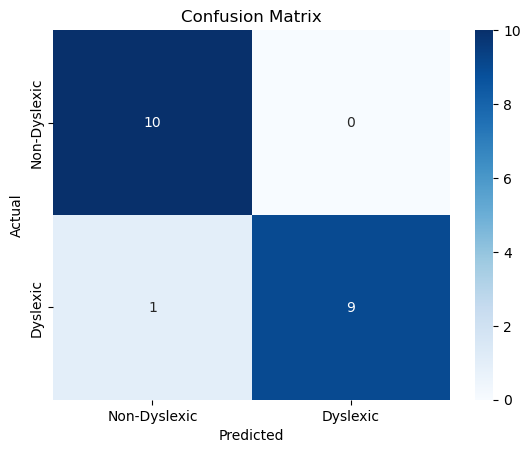

In [23]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Dyslexic', 'Dyslexic'], yticklabels=['Non-Dyslexic', 'Dyslexic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [35]:
import joblib

# Save the trained model to a file
joblib.dump(rf_model, 'random_forest_model3rd.pkl')


['random_forest_model3rd.pkl']

In [24]:
#svm

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

Accuracy: 100.00%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



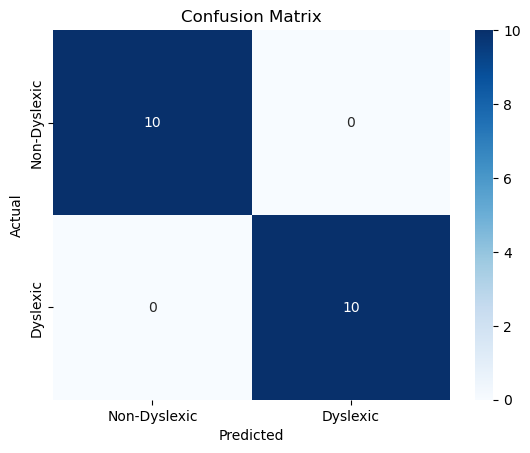

In [26]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Dyslexic', 'Dyslexic'], yticklabels=['Non-Dyslexic', 'Dyslexic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [27]:
#testing

In [28]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import cv2
import numpy as np
import pytesseract
from PIL import Image
import language_tool_python
import nltk
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import joblib

nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Tesseract path (Windows only)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rjabj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 for feature extraction
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()
resnet = resnet.to(device)
resnet.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])



C:\Users\rjabj\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rjabj\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
tool = language_tool_python.LanguageTool('en-US')

def extract_text(image_path):
    image = Image.open(image_path).convert("RGB")
    return pytesseract.image_to_string(image)

def grammar_error_count(text):
    matches = tool.check(text)
    return len(matches)

def sentence_features(text):
    sentences = sent_tokenize(text)
    count = len(sentences)
    avg_len = np.mean([len(s.split()) for s in sentences]) if sentences else 0
    return count, avg_len

def line_alignment_variance(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x_starts = [cv2.boundingRect(c)[0] for c in contours if cv2.boundingRect(c)[2] > 50]
    return np.var(x_starts) if x_starts else 0


In [31]:
def get_features_from_image(image_path):
    # CNN Features
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        cnn_features = resnet(img_tensor).cpu().numpy().flatten()
    
    # Linguistic Features
    text = extract_text(image_path)
    grammar_errors = grammar_error_count(text)
    sentence_count, avg_sentence_length = sentence_features(text)
    alignment_var = line_alignment_variance(image_path)
    
    # Combine features
    full_feature_vector = np.concatenate([
        cnn_features,
        [grammar_errors, sentence_count, avg_sentence_length, alignment_var]
    ])
    
    return full_feature_vector.reshape(1, -1)


In [32]:
def predict_dyslexia(image_path):
    features = get_features_from_image(image_path)
    prediction = rf_model.predict(features)[0]
    proba = rf_model.predict_proba(features)[0]
    
    label = "Dyslexic" if prediction == 1 else "Non-Dyslexic"
    print(f"\n🧠 Prediction: {label}")
    print(f"Confidence: Dyslexic = {proba[1]:.2%}, Non-Dyslexic = {proba[0]:.2%}")


In [33]:
# Replace this path with the actual uploaded image path
test_image_path = r"C:\Users\test_image_path.jpg"

predict_dyslexia(test_image_path)



🧠 Prediction: Dyslexic
Confidence: Dyslexic = 87.00%, Non-Dyslexic = 13.00%


C:\Users\rjabj\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\rjabj\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
